# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and XGBoost, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and XGBoost.

N-Beats is a deep learning model designed specifically for time-series forecasting, while XGBoost is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch 
import os
import sys
import sklearn 
import torch
from utils import DataFrameProcessor, ModelPipeline
import utils
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Data Extraction

In [2]:
processor = DataFrameProcessor('exabel_data')

In [3]:
# / TODO add covid data as it may be a strong covariate for the time series at question
processor.files

['revenue.xlsx', '.DS_Store', 'covid_us.csv', 'spend_amounts_aggregated.xlsx']

In [4]:
revenue = processor.create_df(processor.revenue)
spendings = processor.create_df(processor.spendings)
df = processor.merge_spendings_revenue(spendings, revenue)
df = processor.create_stationary_covariates(df)
df = processor.add_war_to_df(df)
df = processor.encode_index(df)
df = processor.remove_small_tickers(df)
df = processor.remove_missing_ground_truth(df)

## Data Exploration

In [5]:
# total number of companies
len(df['ticker'].unique())

228

In [6]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    709
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

#### Inspecting whether seasonality is justified with including data for companies with 10 rows of data (each row correspond to a fiscal quarter)

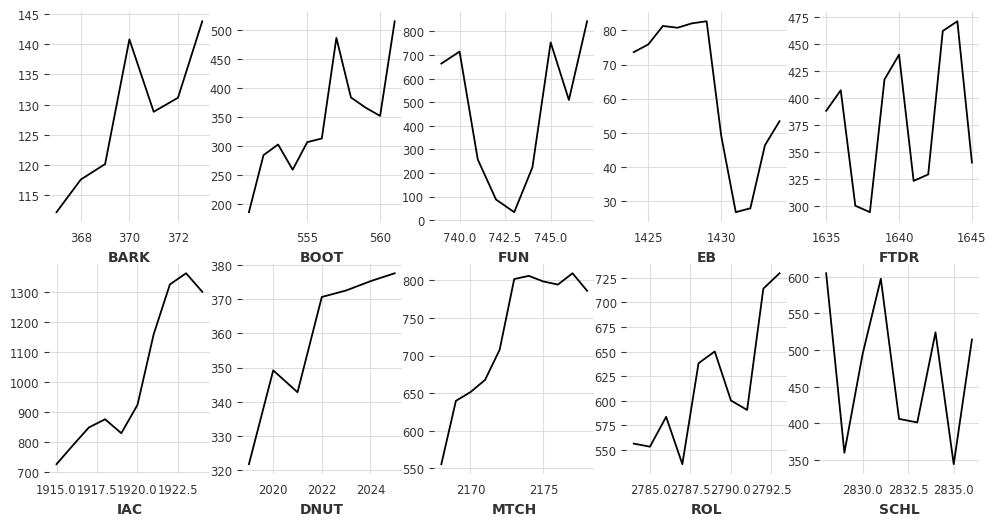

In [7]:
i, j = 0, 0
fig, ax = plt.subplots(2, 5, figsize=(12,6))

for tic in df['ticker'].unique():
    df_copy = df[df['ticker'] == tic]
    if df_copy.shape[0] < 12:
        ax[i][j].plot(df_copy['Sales_Actual_fiscal'])
        ax[i][j].set_xlabel(tic)
        j += 1
        if j == 5:
            j = 0
            i += 1
        if i == 2:
            break
        
plt.show()



In [8]:
def print_nans_index(df):
    """ 
    
    """
    for tic in np.unique(df.ticker):
        df_copy = df[df['ticker'] == tic]
        
        if df_copy.isnull().values.any():
            print('\n')
            print(f"Ticker: {tic}, # Data points: {df_copy.shape[0]}")
        df_copy = df_copy.reset_index(drop=False)
        
        for col in df_copy.columns:
            nan_count = df_copy[col].isnull().sum()
        
            if nan_count > 0:
                nan_indices = df_copy[df_copy[col].isnull()].index.tolist()
                nan_row_counts = [index + 1 for index in nan_indices]
                print(f"Column: {col}, NaN Indices: {nan_indices}")
        
print_nans_index(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEO, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] so that it makes sense to impute these values to avoid missing large amounts of data.

In [9]:
# Correlation Matrix
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
mic,1.000000,-0.015624,0.034246,-0.162790,-0.169496,0.002497,0.003391,0.004694,0.004637
nw_total_sales_a_total,-0.015624,1.000000,0.949305,0.441001,0.441714,0.038018,-0.014009,-0.007605,0.038457
nw_total_sales_b_total,0.034246,0.949305,1.000000,0.473981,0.474393,0.030005,-0.007117,-0.001059,0.024913
Sales_Actual_fiscal,-0.162790,0.441001,0.473981,1.000000,0.998609,0.018723,0.017216,0.003048,0.029760
Sales_Estimate_fiscal,-0.169496,0.441714,0.474393,0.998609,1.000000,0.015167,0.015776,0.001745,0.026734
year,0.002497,0.038018,0.030005,0.018723,0.015167,1.000000,-0.259797,-0.221189,0.664221
month,0.003391,-0.014009,-0.007117,0.017216,0.015776,-0.259797,1.000000,0.972801,-0.081110
quarter,0.004694,-0.007605,-0.001059,0.003048,0.001745,-0.221189,0.972801,1.000000,-0.062520
is_war,0.004637,0.038457,0.024913,0.029760,0.026734,0.664221,-0.081110,-0.062520,1.000000


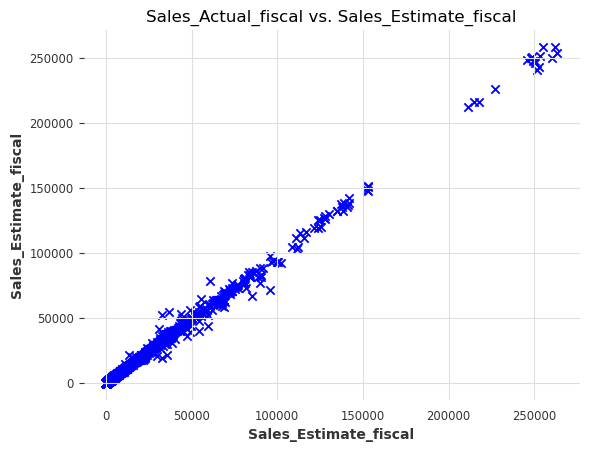

In [10]:
utils.plot_scatter(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

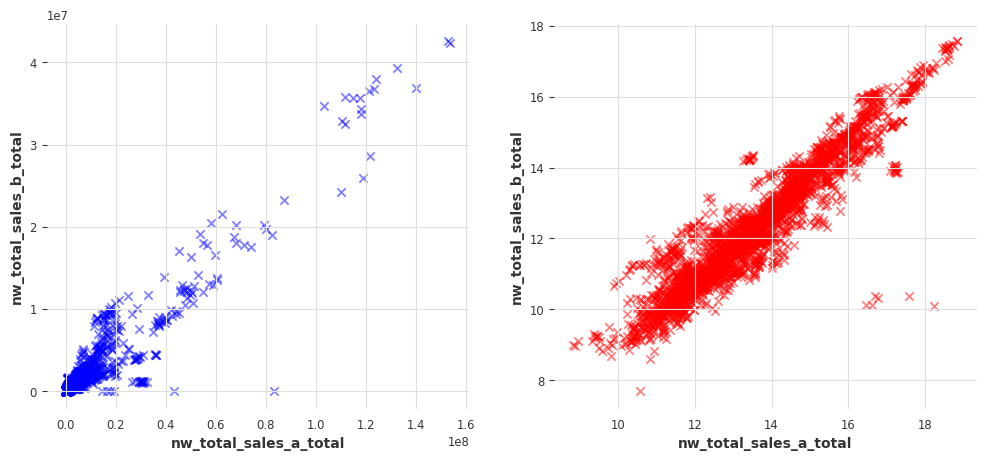

In [11]:
utils.plot_scatter_log(df,'nw_total_sales_a_total', 'nw_total_sales_b_total')

<AxesSubplot: ylabel='Count'>

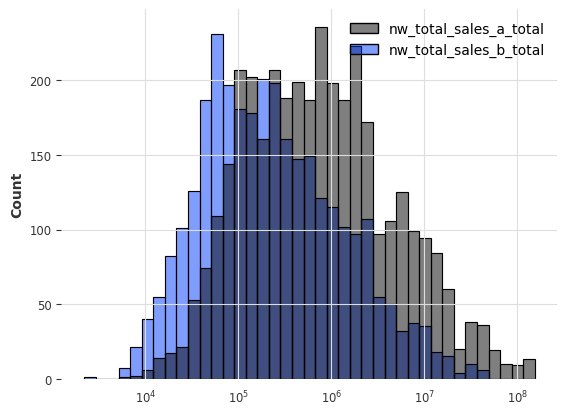

In [12]:
sales_banks_df = df[['nw_total_sales_a_total', 'nw_total_sales_b_total']]
fiscal_sales = df[['Sales_Actual_fiscal', 'Sales_Estimate_fiscal']]
sns.histplot(data=sales_banks_df, log_scale=True)


<AxesSubplot: ylabel='Count'>

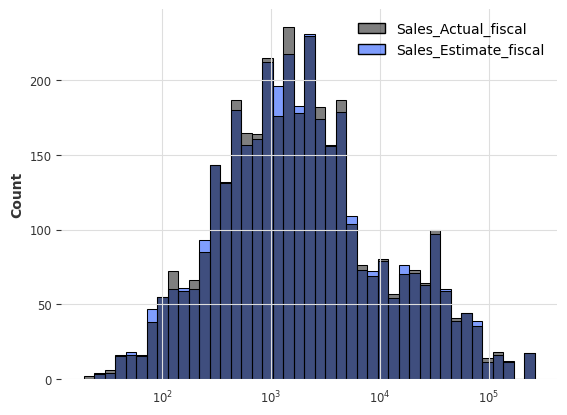

In [13]:
sns.histplot(data=fiscal_sales, log_scale=True)

In [14]:
df = processor.impute_bankB_nans(df, plot=False)

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values, or one can increase the complexity by KNN / KD-Balls (for that, more data per time series would be neccessary), or use polynomial regression. 

In [15]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

### Now we can inspect if there are any more patterns in the NaNs that can be utilized to impute more of the missing data points

In [16]:
# getting data statistics
df.describe()

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
count,3759.000000,3.618000e+03,3.584000e+03,3718.000000,3685.000000,3776.000000,3776.000000,3776.000000,3776.000000
mean,3.542165,4.119470e+06,1.142776e+06,9170.244439,9072.925985,2.218220,7.210011,2.581038,0.188030
std,0.688433,1.230147e+07,3.418338e+06,24210.029727,23885.147076,1.291048,3.360561,1.100897,0.390788
min,0.000000,6.767840e+03,-2.521491e+04,19.143000,24.550000,0.000000,1.000000,1.000000,0.000000
25%,3.000000,1.788466e+05,6.151673e+04,555.507500,563.868700,1.000000,4.000000,2.000000,0.000000
50%,4.000000,6.797947e+05,1.951638e+05,1622.500000,1625.124900,2.000000,7.000000,3.000000,0.000000
75%,4.000000,2.412127e+06,7.251679e+05,4931.474000,4966.615700,3.000000,10.000000,4.000000,0.000000
max,7.000000,1.536824e+08,4.258561e+07,263187.000000,258562.440000,4.000000,12.000000,4.000000,1.000000


In [17]:
# inspecting remaning nans
print_nans_index(df)



Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Co

In [18]:
df = processor.sales_imputation(df, plot=True)

In [19]:
# Correlation Matrix
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
mic,1.000000,-0.015624,0.037177,-0.159141,-0.161415,0.002497,0.003391,0.004694,0.004637
nw_total_sales_a_total,-0.015624,1.000000,0.948652,0.439983,0.441064,0.038018,-0.014009,-0.007605,0.038457
nw_total_sales_b_total,0.037177,0.948652,1.000000,0.468334,0.468960,0.024886,-0.008390,-0.000661,0.023748
Sales_Actual_fiscal,-0.159141,0.439983,0.468334,1.000000,0.998617,0.017397,0.017800,0.004268,0.029729
Sales_Estimate_fiscal,-0.161415,0.441064,0.468960,0.998617,1.000000,0.014471,0.017129,0.003770,0.027796
year,0.002497,0.038018,0.024886,0.017397,0.014471,1.000000,-0.259797,-0.221189,0.664221
month,0.003391,-0.014009,-0.008390,0.017800,0.017129,-0.259797,1.000000,0.972801,-0.081110
quarter,0.004694,-0.007605,-0.000661,0.004268,0.003770,-0.221189,0.972801,1.000000,-0.062520
is_war,0.004637,0.038457,0.023748,0.029729,0.027796,0.664221,-0.081110,-0.062520,1.000000


In [20]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

In [21]:
print_nans_index(df)



Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: nw_total_sa

# Idea: identify a ticker where there are some missing values and use for interpretation, see below and above

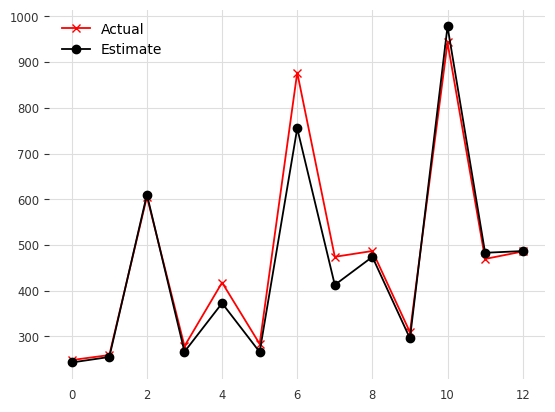

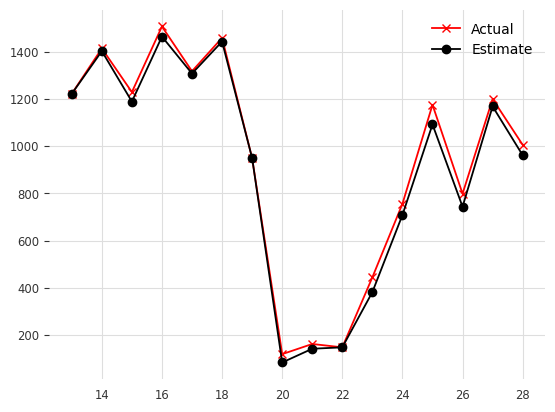

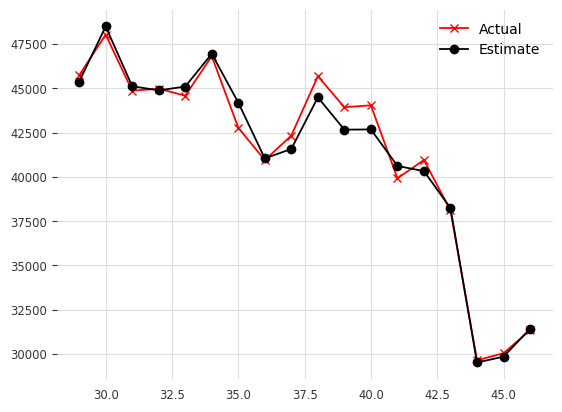

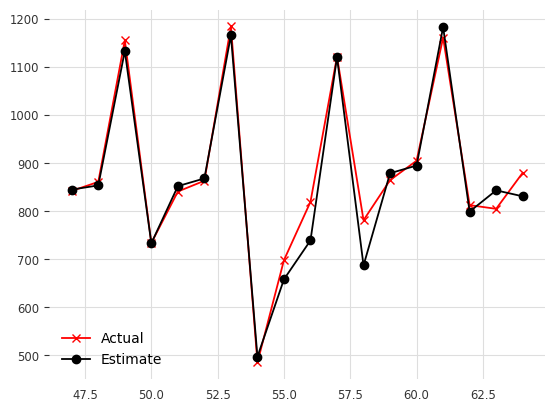

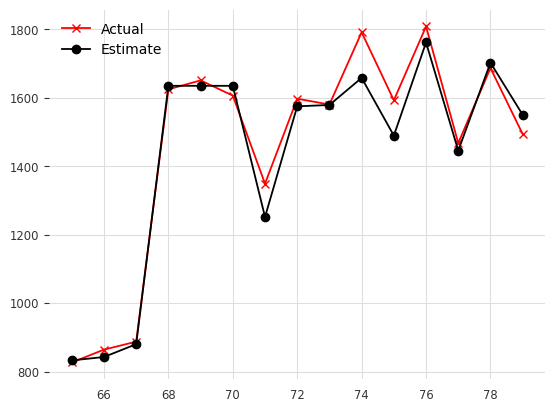

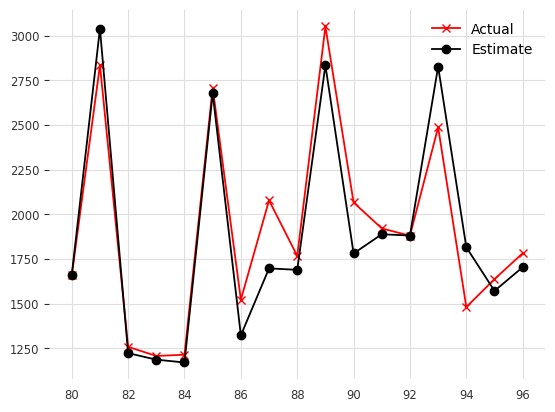

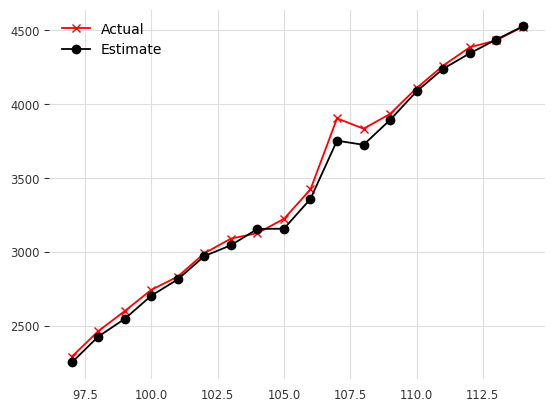

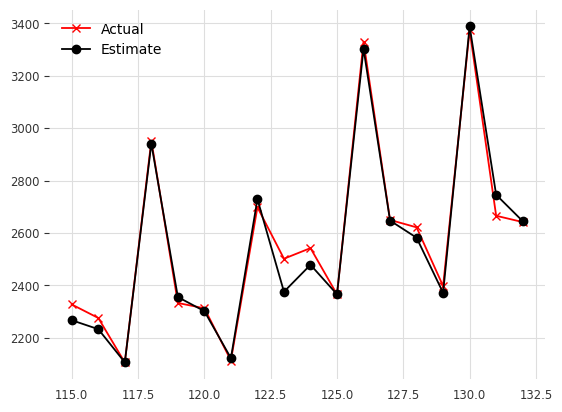

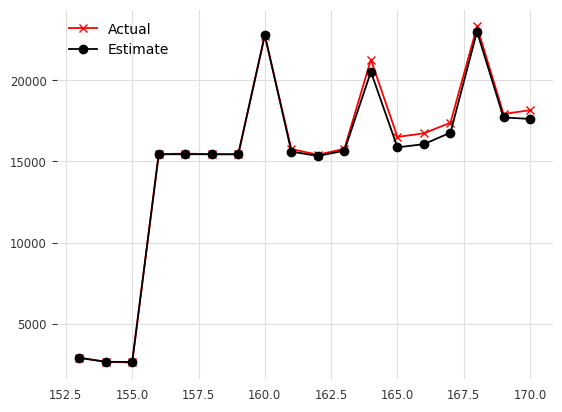

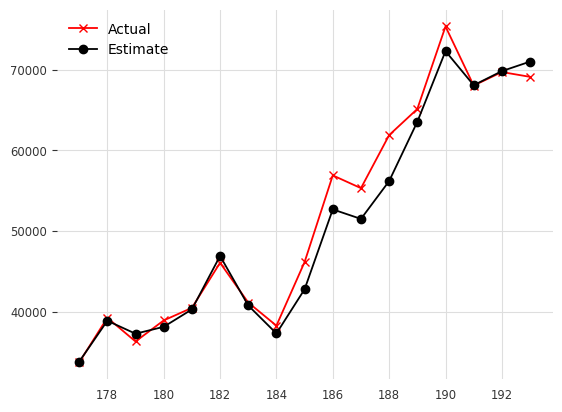

In [22]:
i = 0
for tic in df['ticker'].unique():
    if i < 10:
        df_copy = df[df['ticker'] == tic]
        plt.plot(df_copy['Sales_Actual_fiscal'].index,df_copy['Sales_Actual_fiscal'], label='Actual', marker='x', color='red')
        plt.plot(df_copy['Sales_Estimate_fiscal'].index,df_copy['Sales_Estimate_fiscal'], label='Estimate', marker='o')
        plt.legend()
        plt.show()
        i += 1
    

In [23]:
col_actual, col_estimate = 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal'
mean_abs_diff = np.mean(abs(df[col_actual] - df[col_estimate]))
std_dev = np.sqrt(mean_abs_diff)

for col in [col_estimate, col_actual]:
    mask = df[col].isna()
    other_col = col_estimate if col == col_actual else col_actual
    df.loc[mask, col] = np.random.normal(df[other_col][mask], std_dev, size=(mask.sum(),))
    


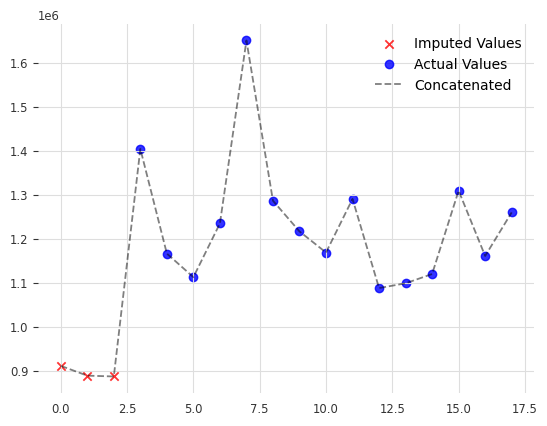

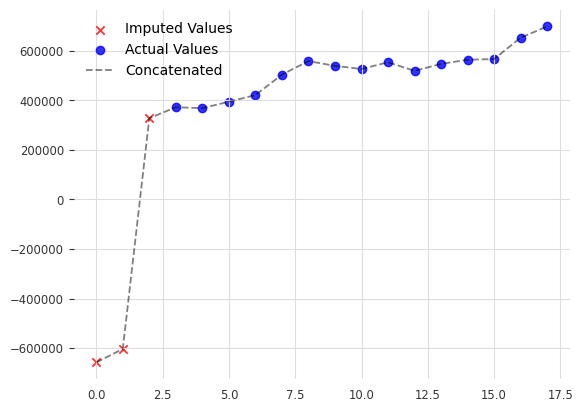

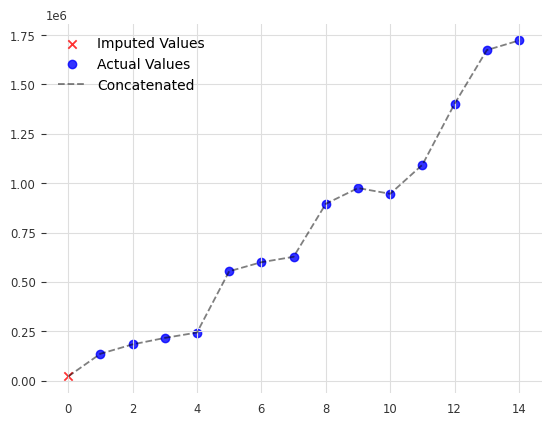

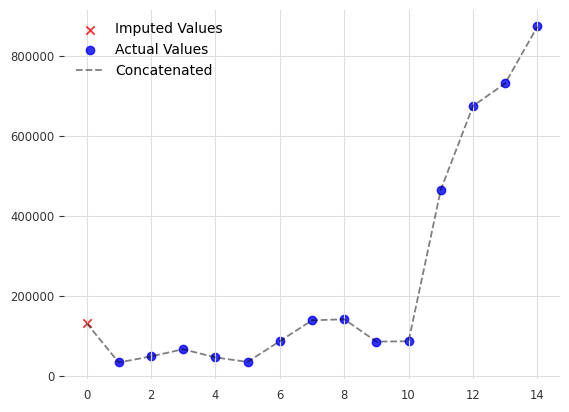

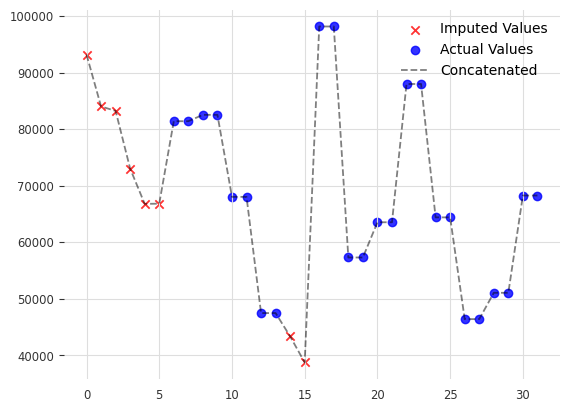

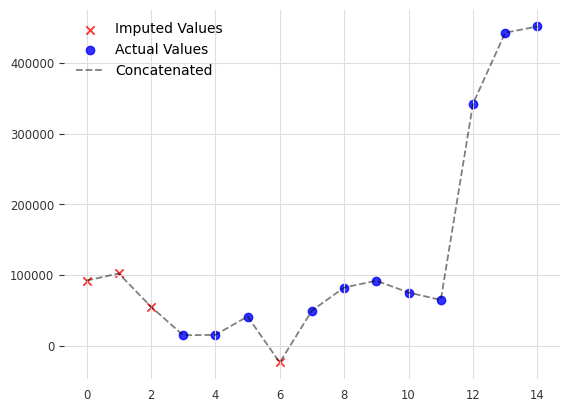

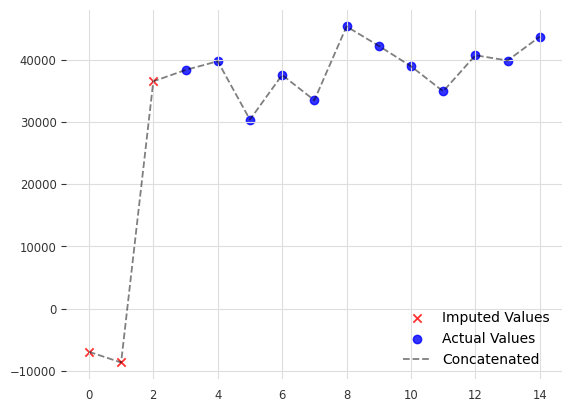

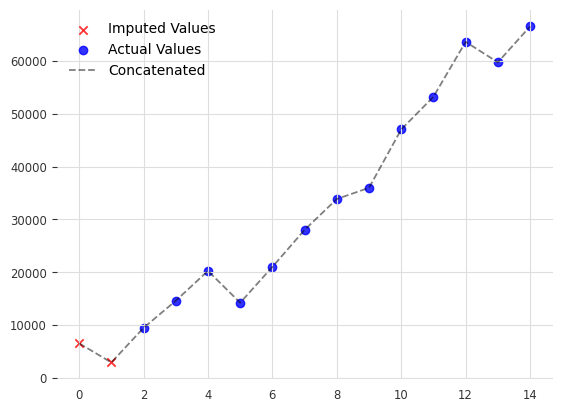

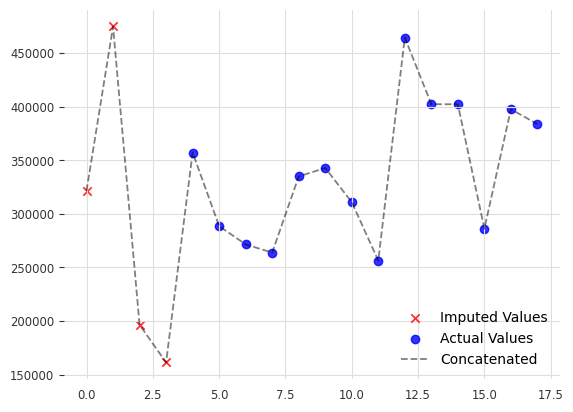

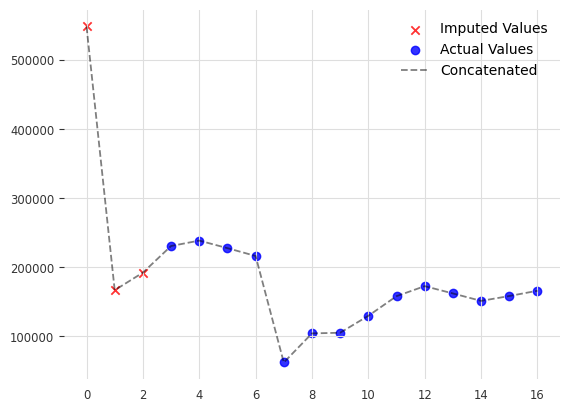

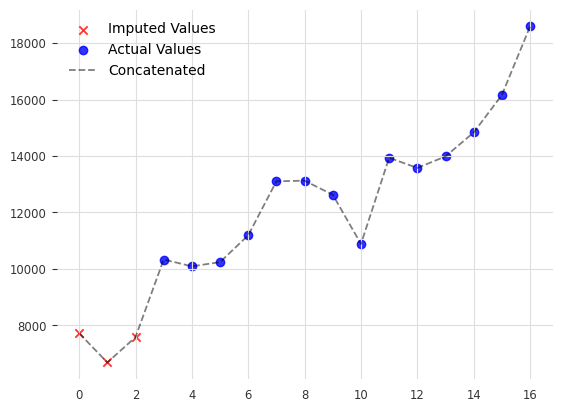

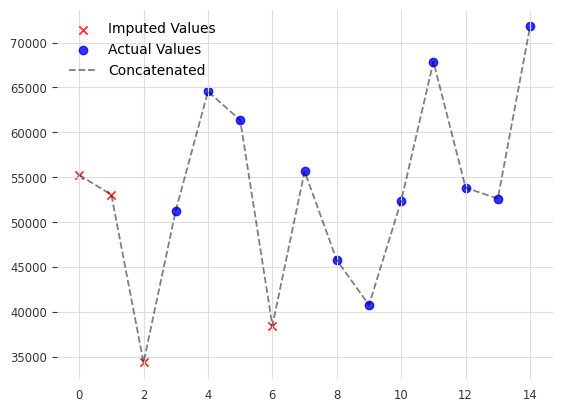

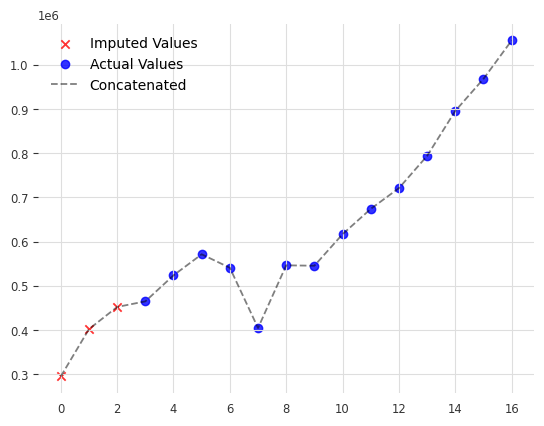

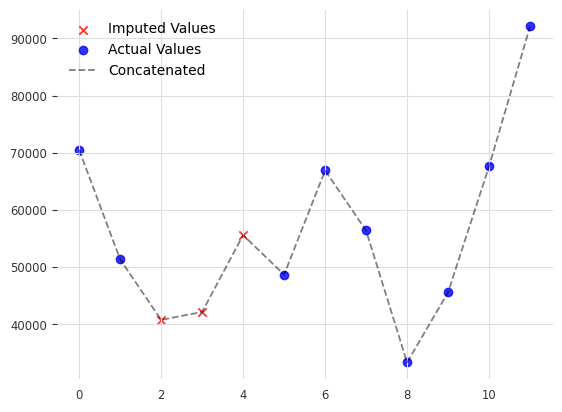

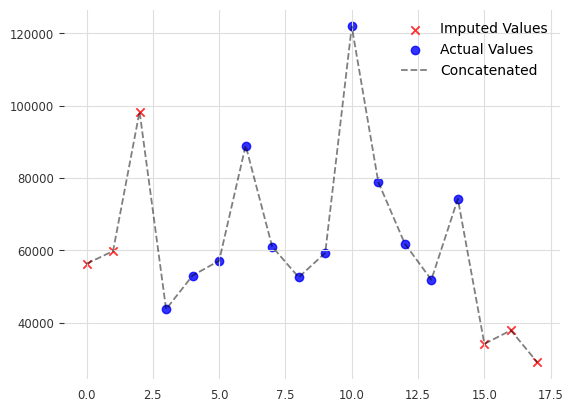

In [24]:
def impute_nans_singular_column(df, proportion = 0.35):
    nan_companines = processor.get_nan_columns(df)

    for tic, column_list in nan_companines.items():
        if len(column_list) == 1:
            df_copy, original_indices, nan_indices = processor.get_nan_indices(df, tic, col=column_list[0])
            if len(nan_indices) / len(original_indices) <= proportion:
                df = processor.least_square_imputation(df, df_copy, tic, original_indices, col=column_list[0],plot=True)
    return df
df = impute_nans_singular_column(df)

In [25]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    141
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

In [26]:
print_nans_index(df)



Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: nw_total_sales_b_total, NaN Indices: [0, 1]


Ticker: CPRI, # Data points: 17
Column: nw_total_sale

In [27]:
# from sklearn.ensemble import HistGradientBoostingRegressor

# def impute_missing_values_KNN(df, proportion =0.5, plot=False):
        
#     nan_companies = processor.get_nan_columns(df)

#     for tic, cols in nan_companies.items():
#         # add if set is less than or equal to three and proportions of all is less than a certain value
#         # can add KNN by ranking - column with lowest number of NaNs is fitted and imputed first
#         # then iteratively do the same for remaining columns from lowest to highest
#         df_copy = df[df['ticker'] == tic]
#         original_indices = df_copy.index
        
#         for col in cols:
#             nan_indices = df_copy[df_copy[col].isnull()].index.tolist()
#             if len(nan_indices) / df_copy.shape[0] < proportion and len(nan_indices) > 1:
#                 # impute missing values using the mean of interpolation and rolling average
#                 df_train = df_copy[df_copy[col].notna()]
#                 df_train = numeric_columns(df_train)
#                 X_train = df_train.drop(col, axis=1)
#                 y_train = df_train[col]
                
#                 print(y_train)
                
#                 X_fit = df_copy[X_train.columns]
#                 X_fit = X_fit[df_copy[col].notna()]

#                 print(X_fit)

#                 estimator = HistGradientBoostingRegressor().fit(X_train,y_train)
#                 y = estimator.predict(X_fit)
                
#                 # df_copy.loc[original_indices, col] = df_copy[col].interpolate(method='linear', limit_direction='both')
#                 df_copy.loc[nan_indices, col] = y
                
#                 df.loc[original_indices, col] = df_copy[col]
                
#                 if plot:
#                     plt.scatter(original_indices, df_copy.loc[original_indices, col], color='red', marker='o')
#                     plt.scatter(nan_indices, df.loc[nan_indices, col], color='blue', marker='x')
#                     plt.plot(df_copy.index, df_copy[col], linestyle='--', color='black')
#                     plt.show()

#             return df

# df = impute_missing_values_KNN(df, plot=True)

# df.isna().sum()


In [28]:
df.isna().sum()

mic                        17
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    141
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
is_war                      0
dtype: int64

In [29]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,mic,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter,is_war
mic,1.000000,-0.015624,0.035531,-0.159141,-0.161415,0.002497,0.003391,0.004694,0.004637
nw_total_sales_a_total,-0.015624,1.000000,0.948688,0.439983,0.441064,0.038018,-0.014009,-0.007605,0.038457
nw_total_sales_b_total,0.035531,0.948688,1.000000,0.467644,0.468226,0.029089,-0.008259,-0.000593,0.024978
Sales_Actual_fiscal,-0.159141,0.439983,0.467644,1.000000,0.998617,0.017397,0.017800,0.004268,0.029729
Sales_Estimate_fiscal,-0.161415,0.441064,0.468226,0.998617,1.000000,0.014471,0.017129,0.003770,0.027796
year,0.002497,0.038018,0.029089,0.017397,0.014471,1.000000,-0.259797,-0.221189,0.664221
month,0.003391,-0.014009,-0.008259,0.017800,0.017129,-0.259797,1.000000,0.972801,-0.081110
quarter,0.004694,-0.007605,-0.000593,0.004268,0.003770,-0.221189,0.972801,1.000000,-0.062520
is_war,0.004637,0.038457,0.024978,0.029729,0.027796,0.664221,-0.081110,-0.062520,1.000000


Here the first 3 values were missing, and even though not necessarily they are 100% ground trouth wrt to the actual data, it makes intuitive sense with the rest of the series, and due to the strong linear dependency between terms, it is reasonable to assume that a least squares solution give approximate results. 

### The next step is to account for different regimes of NaNs
##### These are the cases I have considered:

1. either number of customers in bank A or number of customers in bank B are missing early, then apply LLS if no other values are missing

2. if only intermediary values are missing, we use a rolling average with respect to the column

3. if sales are missing either from estimate or actual, we can use one or the other with additive Gaussian noise to make predictions, as they have a very strong correlation 

4. if large amounts over a certain treshold is missing, we drop that column (or series), and do not use the preceding imputations of columns for those series


## Scaling Data
# TBD
Now, we have large discrepencies between the values for each column. Thus, it makes sense to normalize them and rather scale up after making predictions. 

### After Scaling
We can start by defining columns that can unveil underlying correlations. In doing so, we allow the network to find complex patterns within the data that otherwise would not have been unveiled

In [30]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter', 'is_war'],
      dtype='object')

In [31]:
df_mic1 = df[df['mic'] == 4]

<AxesSubplot: xlabel='month', ylabel='Sales_Actual_fiscal'>

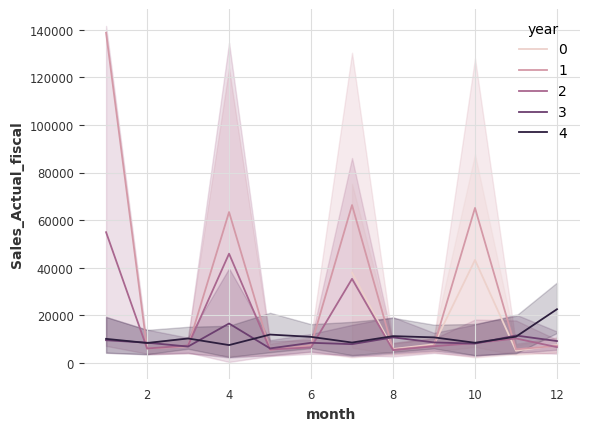

In [32]:
sns.lineplot(data=df_mic1, x='month', y='Sales_Actual_fiscal', hue='year')

In [33]:
df = df.dropna(how='any')
df.shape

(3463, 11)

In [45]:
df = processor.remove_small_tickers(df)
df.shape

(3385, 11)

In [46]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter', 'is_war'],
      dtype='object')

In [47]:
def add_abs_difference(df):
    """ 
    
    """
    df['abs_diff_sales'] = np.abs(df['Sales_Actual_fiscal'] - df['Sales_Estimate_fiscal'])
    df['abs_diff_costumers'] = np.abs(df['nw_total_sales_a_total'] - df['nw_total_sales_b_total'])
    return df

def add_products(df):
    """ 
    
    """
    df['prod_sales'] = df['Sales_Actual_fiscal'] * df['Sales_Estimate_fiscal']
    df['prod_n_customers'] = df['nw_total_sales_a_total'] * df['nw_total_sales_b_total']
    return df

# Building Series from Darts

In [48]:
model = ModelPipeline(df)

In [49]:
series_dict = model.get_covs_target_dict()

In [50]:
series_dict['LULU'][0]

<TimeSeries (DataArray) (time: 18, component: 7, sample: 1)>
array([[[5.74141900e+04],
        [2.93783239e+04],
        [6.67964000e+02],
        [0.00000000e+00],
        [7.00000000e+00],
        [3.00000000e+00],
        [0.00000000e+00]],

       [[6.38525200e+04],
        [3.36834520e+04],
        [7.37523700e+02],
        [0.00000000e+00],
        [1.00000000e+01],
        [4.00000000e+00],
        [0.00000000e+00]],

       [[1.06998020e+05],
        [4.10847718e+04],
        [1.15172440e+03],
        [1.00000000e+00],
...
        [4.00000000e+00],
        [5.00000000e+00],
        [2.00000000e+00],
        [1.00000000e+00]],

       [[2.47761910e+05],
        [8.28290000e+04],
        [1.77386010e+03],
        [4.00000000e+00],
        [7.00000000e+00],
        [3.00000000e+00],
        [1.00000000e+00]],

       [[2.66265890e+05],
        [9.44874600e+04],
        [1.81429720e+03],
        [4.00000000e+00],
        [1.00000000e+01],
        [4.00000000e+00],
        [1.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 2018-09-30 2018-12-31 ... 2022-12-31
  * component  (component) object 'nw_total_sales_a_total' ... 'is_war'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  2018-09-30  2018-12-31  2019-03-31...
    hierarchy:          None

In [51]:
covariates_list, series_list = [], []
for key, val in series_dict.items():
    covariates_list.append(series_dict[key][0])
    series_list.append(series_dict[key][1])

print(series_dict)

{'AMC': (<TimeSeries (DataArray) (time: 17, component: 7, sample: 1)>
array([[[2.99101940e+05],
        [7.91603599e+04],
        [1.22107000e+03],
        [0.00000000e+00],
        [9.00000000e+00],
        [3.00000000e+00],
        [0.00000000e+00]],

       [[3.70809870e+05],
        [9.61234900e+04],
        [1.40193500e+03],
        [0.00000000e+00],
        [1.20000000e+01],
        [4.00000000e+00],
        [0.00000000e+00]],

       [[2.70150770e+05],
        [7.55493790e+04],
        [1.18821790e+03],
        [1.00000000e+00],
...
        [4.00000000e+00],
        [3.00000000e+00],
        [1.00000000e+00],
        [1.00000000e+00]],

       [[3.58579510e+05],
        [8.66081500e+04],
        [1.16782810e+03],
        [4.00000000e+00],
        [6.00000000e+00],
        [2.00000000e+00],
        [1.00000000e+00]],

       [[2.98929210e+05],
        [7.17828700e+04],
        [9.61088800e+02],
        [4.00000000e+00],
        [9.00000000e+00],
        [3.00000000e+00],
        

In [53]:
nbeats = NBEATSModel(input_chunk_length=4, output_chunk_length=1)
nbeats.fit(series=series_list, past_covariates=covariates_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
50.072    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [44]:
for tic in df['ticker'].unique():
    print(df[df['ticker'] == tic].shape[0])

6
16
18
18
4
17
18
18
18
17
17
17
17
18
18
17
17
18
11
2
12
18
17
18
18
18
18
17
18
17
18
16
17
17
18
17
10
13
17
14
2
18
18
17
18
18
18
17
17
18
15
13
18
16
18
18
17
17
17
18
16
18
17
18
18
18
17
18
18
17
15
15
17
18
18
32
17
6
17
17
16
18
18
18
8
15
18
18
15
12
18
18
10
18
18
17
17
17
18
17
17
6
9
4
13
18
18
18
18
11
18
3
13
18
17
18
18
17
11
18
17
18
16
17
18
11
18
17
17
18
17
18
7
8
18
17
14
17
16
12
13
18
17
17
4
18
17
17
18
17
5
16
17
5
11
17
17
9
17
18
17
17
17
17
18
17
17
17
18
18
17
18
17
18
17
12
17
16
18
18
17
13
18
18
16
17
18
18
17
1
17
17
18
15
18
18
17
4
18
17
17
11
18
2
17
18
18
1
17
18
17
17
17
17
10
18
17
15
16
18
